### Target:

- Get the basic model skeleton right. I have to avoid changing this skeleton as much as possible
- No fancy stuff
- No BatchNorm layers, No Dropout, No Padding
- Use squeeze and expand kind of model architecture
- At least get 99% on test data

### Results:

- Parameters: 261K
- Best Training Accuracy: 98.49
- Best Test Accuracy: 99.02

### Analysis:

- The model is working but the number of parameters are still large
- Test accuracy is higher than training accuracy which shows that the model has the potential to reach the target

# Import Libraries

In [15]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [16]:
# Train Phase transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test Phase transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    transforms.Normalize((0.1325,), (0.3104,))
    ])


# Dataset and Creating Train/Test Split

In [17]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [18]:
SEED = 8

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8170)
 - mean: tensor(-0.0110)
 - std: tensor(0.8580)
 - var: tensor(0.7361)
torch.Size([512, 1, 28, 28])
torch.Size([512])


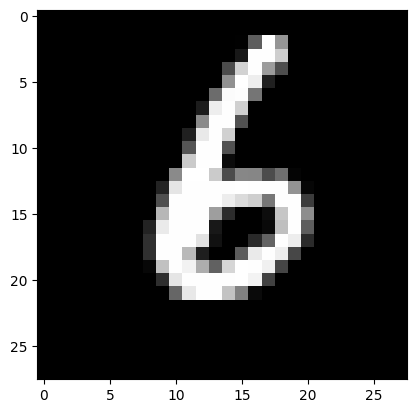

In [19]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray')


origingal


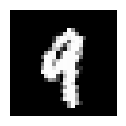

 
centercrop


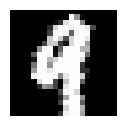

 
resize


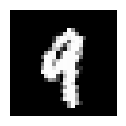

 
rotation


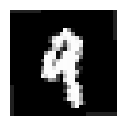

 
normalize


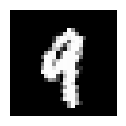

In [20]:
import numpy as np

def plot(imgs, title=None):
    figure = plt.figure(figsize=(5,5))
    num_of_images = len(imgs)
    for index in range(0, num_of_images):
        plt.subplot(4,3,index+1)
        plt.axis('off')
        if title:
            plt.title=title
        plt.imshow(imgs[index].numpy().squeeze(), cmap='gray')
        plt.tight_layout()
        plt.xticks([])
        plt.yticks([])
        plt.show()

batch = next(iter(train_loader))
imgs, labels = batch[0], batch[1]
orig_img, label = imgs[0], labels[0]
orig_img = orig_img.unsqueeze(0)

transformations = {
    'centercrop': transforms.RandomApply([transforms.CenterCrop(20), ], p=1.0),
    'resize': transforms.Resize((28, 28)),
    'rotation': transforms.RandomRotation((-15., 15.), fill=0),
    'normalize': transforms.Normalize((0.1307,), (0.3081,)),
}

print("origingal")
plot(orig_img)

for key, trans in transformations.items():
    print(" ")
    print(key)
    out = trans(orig_img)
    plot(out)

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

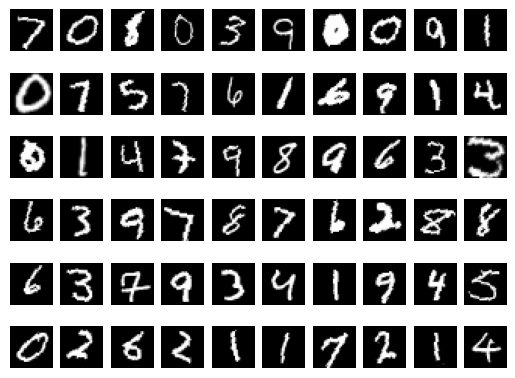

In [21]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray')

# The model
- Let's start with the expand and squeeze model architecture
- The number of channels in a block will keep on increasing. In the transition block, the number of channels will be reduced

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=0, bias=False)       # 28 > 26 | 3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=0, bias=False)      # 26 > 24 | 5
        self.conv3 = nn.Conv2d(64, 128, 3, padding=0, bias=False)     # 24 > 22 | 7

        self.pool1 = nn.MaxPool2d(2, 2)                               # 22 > 11 | 8

        self.conv4 = nn.Conv2d(128, 32, 3, padding=0, bias=False)     # 11> 9 | 12
        self.conv5 = nn.Conv2d(32, 64, 3, padding=0, bias=False)      # 9 > 7 | 16
        self.conv6 = nn.Conv2d(64, 128, 3, padding=0, bias=False)     # 7 > 5 | 20

        self.conv7 = nn.Conv2d(128, 32, 3, padding=0, bias=False)     # 5 > 3 | 24
        self.conv8 = nn.Conv2d(32, 10, 3, padding=0, bias=False)      # 3 > 1 | 28

    def forward(self, x):
        x = F.relu(self.conv3(F.relu(self.conv2(F.relu(self.conv1(x))))))
        x = self.pool1(x)
        x = F.relu(self.conv6(F.relu(self.conv5(F.relu(self.conv4(x))))))
        x = self.conv8(F.relu(self.conv7(x)))
        x = x.view(-1, 10)                                             # 1x1x10 > 10
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [23]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
            Conv2d-2           [-1, 64, 24, 24]          18,432
            Conv2d-3          [-1, 128, 22, 22]          73,728
         MaxPool2d-4          [-1, 128, 11, 11]               0
            Conv2d-5             [-1, 32, 9, 9]          36,864
            Conv2d-6             [-1, 64, 7, 7]          18,432
            Conv2d-7            [-1, 128, 5, 5]          73,728
            Conv2d-8             [-1, 32, 3, 3]          36,864
            Conv2d-9             [-1, 10, 1, 1]           2,880
Total params: 261,216
Trainable params: 261,216
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB):

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [24]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [25]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=1.8914155960083008 Batch_id=117 Accuracy=21.19: 100%|██████████| 118/118 [00:52<00:00,  2.24it/s]



Test set: Average loss: 1.9293, Accuracy: 3111/10000 (31.11%)

EPOCH: 1


Loss=0.3261789381504059 Batch_id=117 Accuracy=75.13: 100%|██████████| 118/118 [00:45<00:00,  2.57it/s]



Test set: Average loss: 0.2172, Accuracy: 9320/10000 (93.20%)

EPOCH: 2


Loss=0.1468765288591385 Batch_id=117 Accuracy=92.79: 100%|██████████| 118/118 [00:43<00:00,  2.74it/s]



Test set: Average loss: 0.1298, Accuracy: 9597/10000 (95.97%)

EPOCH: 3


Loss=0.20549790561199188 Batch_id=117 Accuracy=95.23: 100%|██████████| 118/118 [00:43<00:00,  2.69it/s]



Test set: Average loss: 0.0919, Accuracy: 9724/10000 (97.24%)

EPOCH: 4


Loss=0.1208643987774849 Batch_id=117 Accuracy=96.32: 100%|██████████| 118/118 [00:42<00:00,  2.75it/s]



Test set: Average loss: 0.0560, Accuracy: 9831/10000 (98.31%)

EPOCH: 5


Loss=0.08561667054891586 Batch_id=117 Accuracy=96.78: 100%|██████████| 118/118 [00:42<00:00,  2.78it/s]



Test set: Average loss: 0.0592, Accuracy: 9816/10000 (98.16%)

EPOCH: 6


Loss=0.050370972603559494 Batch_id=117 Accuracy=97.31: 100%|██████████| 118/118 [00:42<00:00,  2.80it/s]



Test set: Average loss: 0.0484, Accuracy: 9842/10000 (98.42%)

EPOCH: 7


Loss=0.07378608733415604 Batch_id=117 Accuracy=97.57: 100%|██████████| 118/118 [00:43<00:00,  2.69it/s]



Test set: Average loss: 0.0447, Accuracy: 9857/10000 (98.57%)

EPOCH: 8


Loss=0.05157073214650154 Batch_id=117 Accuracy=97.69: 100%|██████████| 118/118 [00:42<00:00,  2.77it/s]



Test set: Average loss: 0.0455, Accuracy: 9853/10000 (98.53%)

EPOCH: 9


Loss=0.016519980505108833 Batch_id=117 Accuracy=97.92: 100%|██████████| 118/118 [00:42<00:00,  2.81it/s]



Test set: Average loss: 0.0483, Accuracy: 9835/10000 (98.35%)

EPOCH: 10


Loss=0.08036564290523529 Batch_id=117 Accuracy=98.03: 100%|██████████| 118/118 [00:42<00:00,  2.79it/s]



Test set: Average loss: 0.0412, Accuracy: 9872/10000 (98.72%)

EPOCH: 11


Loss=0.04111574962735176 Batch_id=117 Accuracy=98.30: 100%|██████████| 118/118 [00:43<00:00,  2.74it/s]



Test set: Average loss: 0.0323, Accuracy: 9895/10000 (98.95%)

EPOCH: 12


Loss=0.0161401629447937 Batch_id=117 Accuracy=98.28: 100%|██████████| 118/118 [00:42<00:00,  2.76it/s]



Test set: Average loss: 0.0336, Accuracy: 9888/10000 (98.88%)

EPOCH: 13


Loss=0.07247559726238251 Batch_id=117 Accuracy=98.40: 100%|██████████| 118/118 [00:44<00:00,  2.66it/s]



Test set: Average loss: 0.0306, Accuracy: 9899/10000 (98.99%)

EPOCH: 14


Loss=0.03483964875340462 Batch_id=117 Accuracy=98.43: 100%|██████████| 118/118 [00:43<00:00,  2.74it/s]



Test set: Average loss: 0.0312, Accuracy: 9894/10000 (98.94%)



In [26]:
# train_losses

In [27]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

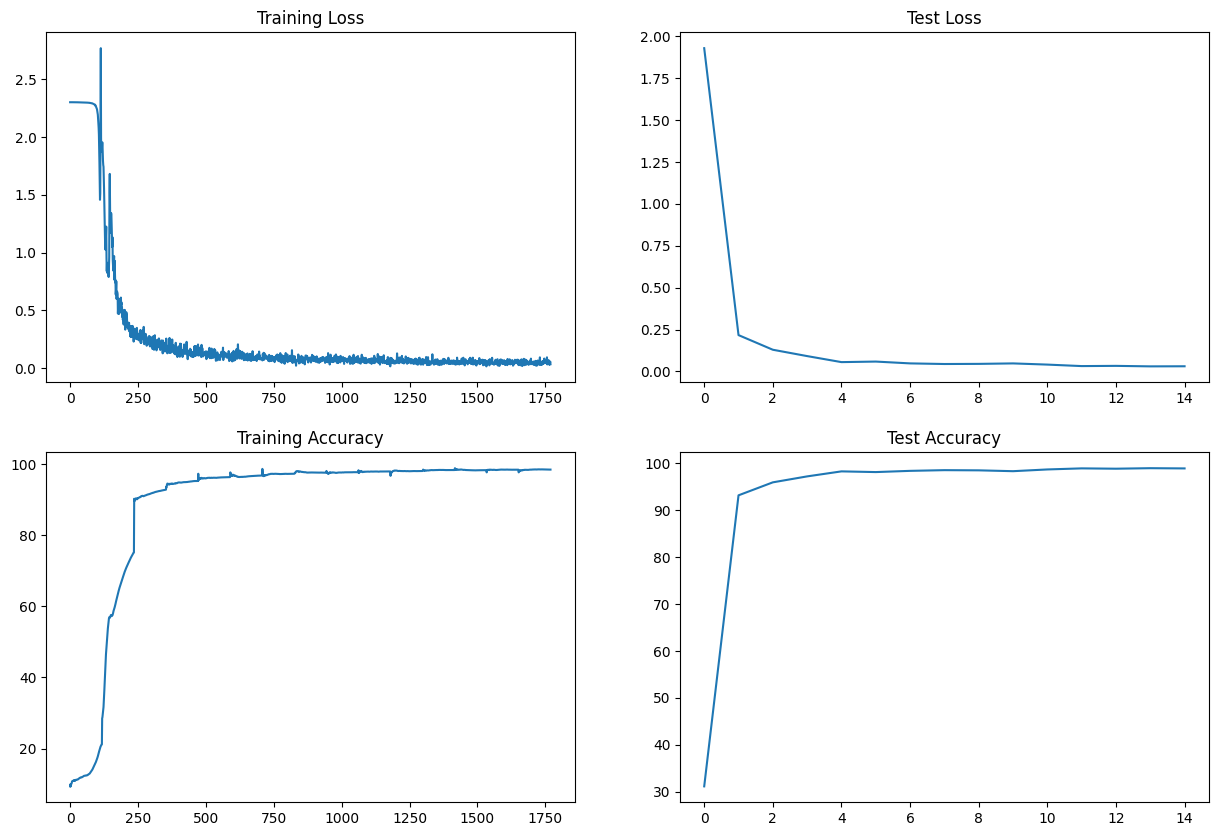

In [28]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")